Ring Trap v. Arrangement of Tweezers

# PART 1. Single Optical Tweezer

In [26]:
import numpy as np
from scipy import special as sp
from scipy import constants as sc
from scipy.integrate import simps
from matplotlib import pyplot as plt
from matplotlib import cm

#define physical quantities
P = 1 #power ~ 1 Watt
pi = sc.pi
e_0 = sc.epsilon_0 #vacuum permittivity
wavelength = 1064*10**-9 
w_0 = 1*10**-6 #beam waist
z_R = pi*w_0**2/wavelength #Rayleigh range (~2.9 um)

def force_field_axial(x, y, z, a, n_p, n_m):
    #returns the trapping and scattering forces at any pt due to optical trap
    k = 2*pi/wavelength #multiply by n_m? #propagation in air, not medium, right?
    r = np.sqrt(x**2 + y**2) 
    #xi, zeta are dimensionless quantities to help with computation
    zeta = z_R**2 / (z**2 + z_R**2)
    xi = r/w_0
    alpha = 4 * pi * e_0 * n_m**2 * a**3 * (n_p**2 - n_m**2)/(n_p**2 + 2*n_m**2) #Clausius-Mossotti
    b = k**3/(6*pi*e_0*n_m**2)
    alpha_real = alpha/(1+b**2*alpha**2)
    alpha_im = b*alpha**2/(1+(b**2*alpha**2))
    u_0 = np.sqrt(P/(pi*(w_0**2*(1+(z/z_R)**2)))) #intensity is proportional to u_0^2. And u_0^2 is power/area
    u_sq = u_0**2 * zeta * np.exp(-2*xi**2*zeta)
    grad_phase = k - zeta/z_R + (1/2*k*r**2*(zeta**2/z_R**2 - z**2/(z_R**2+z**2)))
    grad_force = 1/4 * alpha_real * u_0**2 * zeta**2 * np.exp(-2*zeta*xi)*z/z_R**2 * (4*xi*zeta-2) #trapping force
    scat_force = 1/2 * u_sq * grad_phase * (b*alpha**2)/(1+b**2*alpha**2) #scattering force
    return [grad_force, scat_force]
    ###checking with photokinetic paper results
    f_1 = -(1/(k*z_R) - r**2/(z**2+z_R**2))*z/z_R #f_0 * f_1 is trap force
    f_2 = alpha_im / alpha_real * (1- 1/(k*z_R) + (z/z_R)**2 - 0.5*(r/z_R)**2*((z**2-z_R**2)/(z**2+z_R**2))) #f_0 * f_2 is scat force
    f_0 = 1/2 * k * u_sq * (z_R**2 / (z**2+z_R**2))*alpha_real #force scale
    
def explore_z(a, n_p, n_m):
    x, y = 0,0
    z_list = np.arange(0, 10**-5, 10**-8)
    trap_list = [force_field_axial(x, y, z, a, n_p, n_m)[0] for z in z_list]
    scat_list = [force_field_axial(x, y, z, a, n_p, n_m)[1] for z in z_list]
    f = plt.figure(figsize=(10,3))
    #begin plotting...
    #define a big suplot, and turn off ticks
    ax = f.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax.set_xlabel('z (m)')
    ax.set_title('Low index sphere')
    #plot data
    ax1 = f.add_subplot(121)
    ax1.plot(z_list, trap_list, 'b-')
    ax1.set_ylabel('Gradient Force (N)')
    ax2 = f.add_subplot(122)
    ax2.plot(z_list, scat_list, 'r-')
    ax2.set_ylabel('Scattering Force (N)')
    min_index, max_index = [q for q, value in enumerate(trap_list) if value == min(trap_list)], [q for q, value in enumerate(trap_list) if value == max(trap_list)] 
    print('min @ z = ', z_list[min_index[0]], ',', '\t','max @ z = ', z_list[max_index[0]])

def f_grav(a):
    #gravity
    rho = 2.65*10**3 #silica
    return 4/3*pi*a**3*rho * 9.81

min @ z =  0.0 , 	 max @ z =  1.32e-06


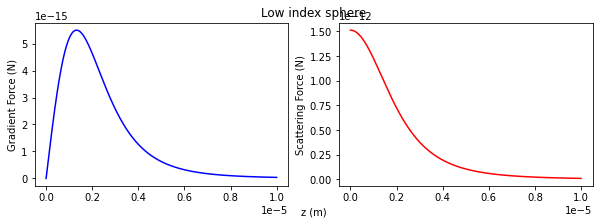

In [7]:
explore_z(1*10**-6, 1.42, 1.49)

min @ z =  1.32e-06 , 	 max @ z =  0.0


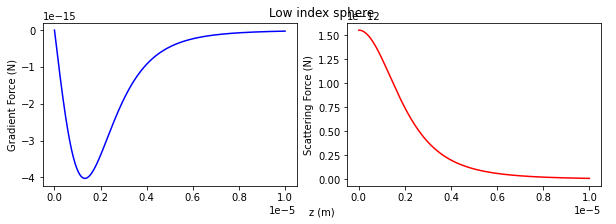

In [74]:
explore_z(1*10**-6, 1.59, 1.49)

### It bears noting that the sign of the optical trapping is also dependent on the dimensionless quantities $\zeta$ and $\xi$, which is most unexpected, as it was thought to solely depend on physical paramters $n_m$ and $n_p$. The order of magnitude of these forces -- thought to be of pN size -- is way off. 

# PART 2. Superposition of Optical Tweezers

In [36]:
def circle(rc, npts):
    #output array of pts that form circle of radius rc
    circ = []
    thetapts = np.arange(0, 2*pi, 2*pi/npts)
    for theta in thetapts:
        circ.append((rc*np.cos(theta), rc*np.sin(theta)))
    return circ

def force_field_SOT(z, a, n_p, n_m, npts):
    #first, generate collection of optical tweezers
    my_tweezers = circle(a*20, npts)
    xmax = 1*10**-4
    dx = 1*10**-6
    force_field_SOT = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))])
    for xi in range(int(xmax/dx)):
        for yi in range(int(xmax/dx)):
            x = (xi - (xmax/(2*dx))) * dx
            y = (yi - (xmax/(2*dx))) * dx
            f_z = 0
            for trap_pos in my_tweezers:
                xt = trap_pos[0]
                yt = trap_pos[1]
                zt = 0 #assume traps are all in z=0 plane
                f_z+=force_field_axial(x-xt, y-yt, z-zt, a, n_p, n_m)[0] #return axial force, superposed
            force_field_SOT[xi][yi] = f_z
    scale = str(dx) + '/px'
    plt.title('Collection of OT ->' + 'Scale = ' + str(scale))
    plt.imshow(force_field_SOT, cmap = 'viridis', interpolation = 'nearest')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    return

def landscape_3d_xz_SOT(y, a, n_p, n_m, npts):
    #first, generate collection of optical tweezers
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    my_tweezers = circle(a*20, npts)
    xmax, zmax = 1*10**-4, 1*10**-5
    dx, dz = 1*10**-6, 1*10**-6
    xlist = np.linspace(-xmax, xmax, 100)
    zlist = np.linspace(0, zmax, 100)
    force_field_SOT = np.zeros([len(xlist), len(zlist)])
    for xi in range(int(xmax/dx)):
        for zi in range(int(xmax/dx)):
            x = xlist[xi]
            z = zlist[zi]
            f_z = 0
            for trap_pos in my_tweezers:
                xt = trap_pos[0]
                yt = trap_pos[1]
                zt = 0 
                f_z+=force_field_axial(x-xt, y-yt, z-zt, a, n_p, n_m)[0] 
            force_field_SOT[xi][zi] = f_z
    X,Z = np.meshgrid(xlist,zlist)
    surf = ax.plot_surface(X, Z, force_field_SOT, cmap = cm.coolwarm, linewidth=0, antialiased=False) 
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    #ax.set_zlabel('Intensity')
    ax.set_zlabel('Force')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

<IPython.core.display.Javascript object>


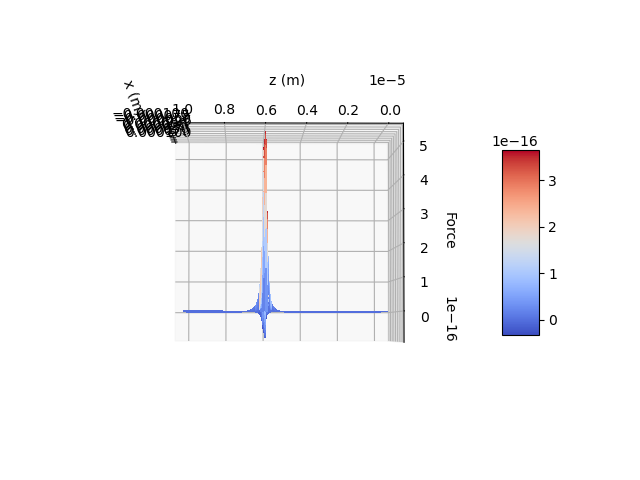

In [41]:
landscape_3d_xz_SOT(1e-6, 1e-6, 1.59, 1.49, 1)

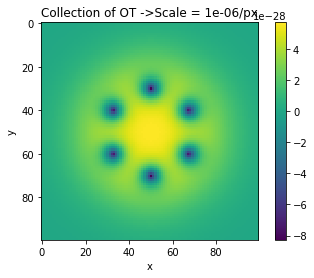

In [48]:
force_field_SOT(10*10**-6, 1*10**-6, 1.59, 1.49, 6)

<IPython.core.display.Javascript object>


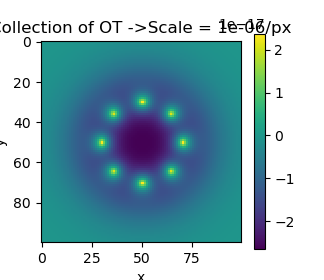

In [91]:
force_field_SOT(10*10**-6, 1*10**-6, 1.42, 1.49, 8)

# PART 3. Ring trap

#### Rayleigh Sommerfeld is exact, and almost impossible to compute for non-trivial geometry. Fraunhofer (far-field) and Fresnel (paraxial) approximations can be considered. Here, use Fresnel.
#### Integral:
### $\frac{1}{i\lambda z} \times e^{ik(z+\frac{r^2}{2z})} \times \int_{0}^{\infty}\int_{0}^{2\pi}\rho d\rho d\phi J_m(\frac{\rho\pi R}{\lambda f}) e^{im\phi} e^{\frac{ik}{2z}[\rho^2 - r\rho cos(\phi - \theta)]}$

In [3]:
m = 20 #topological charge
k = 2*pi/wavelength
R = 1*10**-5

def f(rho, phi, r, theta, z):
    focus = 2*z
    integrand = rho * sp.jv(m,rho*pi*R/(wavelength*focus)) * np.exp(1j*m*phi) * np.exp(1j*k*(rho**2-(r*rho*np.cos(phi-theta)))/(2*z))
    return integrand

def my_integral(rho, phi, r, theta, z): #cylindrical coordinates
    #use Simpson's rule to evaluate integral. Use romberg or gaussian quadrature instead?
    zz = f(rho.reshape(-1,1),phi.reshape(1,-1), r, theta, z) #reshape to use broadcasting
    ans = simps([simps(zz_rho, rho) for zz_rho in zz], phi) #integrate over rho first, then over phi
    return ans

def ring_intensity_landscape(z):  
    xmax = 1*10**-4
    dx = 1*10**-6
    rho = np.arange(0, xmax-dx, dx) #radial bounds #np.arange behaves weirdly sometimes, and xmax-dx may be replaced by xmax
    phi = np.arange(0, 2*pi, 2*pi/100) #angular bounds 
    xlist = [dx*xi - (xmax/2) for xi in range(int(xmax/dx))]
    ylist = [dx*yi - (xmax/2) for yi in range(int(xmax/dx))]
    ring_field = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))])
    for xi in range(int(xmax/dx)):
        for yi in range(int(xmax/dx)):
            r = np.sqrt(xlist[xi]**2 + ylist[yi]**2)
            prefactor = (1j*wavelength*z)**(-1) * np.exp(1j*k*(z+(r**2/(2*z)))) 
            if xlist[xi]==0:
                theta = pi/2
            else:
                theta = np.arctan(ylist[yi]/xlist[xi])
            u = my_integral(rho, phi, r, theta, z) * prefactor
            ring_field[xi][yi] = np.imag(u)**2 + np.real(u)**2
    plt.imshow(ring_field, cmap = 'viridis', interpolation = 'nearest')
    title = 'Ring Field @ z = ' + str(z) + ', m = ' + str(m)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    return

def intensity_z(x,y):
    #make a plot of intensity as a function of z
    r = x**2 + y**2
    if x==0:
        theta = pi/2
    else:
        theta = np.arctan(y/x)
    xmax, dx = 1*10**-4, 1*10**-6
    rho = np.arange(0, xmax-dx, dx) #radial bounds
    phi = np.arange(0, 2*pi, 2*pi/100) #angular bounds 
    z_list = np.arange(10**-6, 10**-5, 10**-6)
    u_list = [my_integral(rho, phi, r, theta, z) * (1j*wavelength*z)**(-1) * np.exp(1j*k*(z+(r**2/(2*z)))) for z in z_list]
    int_list = [np.imag(u)**2 + np.real(u)**2 for u in u_list]
    plt.plot(z_list, u_list, 'b-')
    title = 'Ring Field intensity for '+ 'm = ' + str(m)
    plt.title(title)
    plt.xlabel('z (m)')
    plt.ylabel('Intensity')

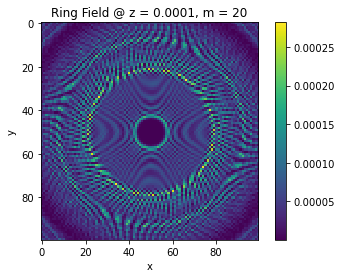

In [105]:
ring_intensity_landscape(0.0001)

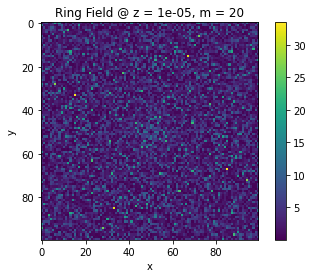

In [104]:
ring_intensity_landscape(1*10**-5)

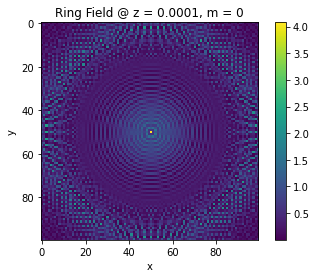

In [107]:
ring_intensity_landscape(0.0001)

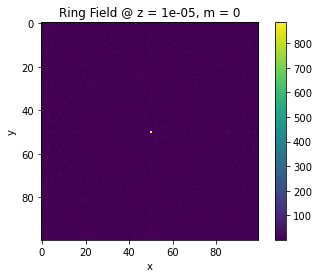

In [109]:
ring_intensity_landscape(1*10**-5)

c:\users\ajati\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


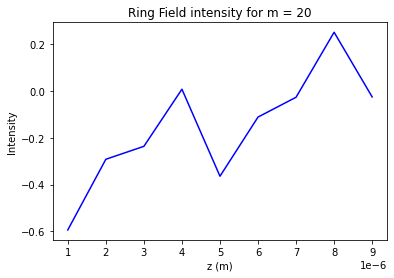

In [17]:
intensity_z(0,0)

c:\users\ajati\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


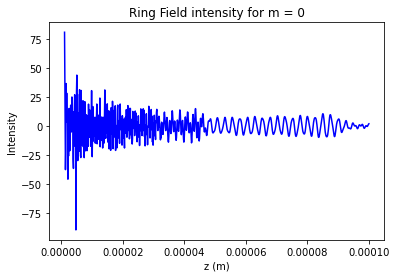

In [160]:
intensity_z(0,0)

### The nature of the fluctuations in intensity seem to purely numerical, and so it does not make much sense to extract the force from intensity gradient, here

# PART 4. From potential to hologram...

## A collection of tweezers seems to work better than a ring trap, and so, we seek a holograpm for a given potential (ignoring non-conservative forces). To this end, the following considerations are made:
1. A trap that has a gaussian potential well, and does not allow particle to leak in x-z plane
2. A trap that maximizes intensity gradient at (0,0), and at z = f, the focal point
3. A trap that has a phase profile consistent with Maxwell's wave equation
4. A trap for which the numerical aperture is large 
## Once these considerations are made, we seek the hologram that gives us such a trap...

#### Construct a potential well. Need an amplitude (choose one that diverges parabolically in z), a gaussian function, and a third function that prevents particle from leaking out
#### Potential, U = I = $u^2$, where scalar field is
#### $u = u_0 \times \mathrm{exp}(-\frac{(x^2 + y^2 + (z-f)^2)}{\lambda f}) $, where $u_0^2 = \frac{P}{\pi(w_0^2)(1+[z/z_R]^2)}$


In [133]:
import numpy as np
from scipy import special as sp
from scipy import constants as sc
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib notebook

#define physical quantities
P = 1 #power ~ 1 Watt
pi = sc.pi
e_0 = sc.epsilon_0 #vacuum permittivity
wavelength = 1064*10**-9 
k = 2*pi/wavelength
w_0 = 1*10**-6 #beam waist
z_R = pi*w_0**2/wavelength #Rayleigh range (~2.9 um)
f = 5*10**-6

#to get a feel for what the force field might look like for particles of different refractive indices, 
#use polarizability information
n_m = 1.49
#n_p = 1.42 #silica
n_p = 1.59 #PS
a = 1*10**-6
alpha = 4 * pi * e_0 * n_m**2 * a**3 * (n_p**2 - n_m**2)/(n_p**2 + 2*n_m**2) #Clausius-Mossotti
b = k**3/(6*pi*e_0*n_m**2)
alpha_real = alpha/(1+b**2*alpha**2)
    
def proj_intensity(x,y,z):
    #gaussian intensity field (potential) at focus
    u_0 = np.sqrt(P/(pi*(w_0**2*(1+(z/z_R)**2)))) #intensity is proportional to u_0^2. And u_0^2 is power/area
    rho = np.sqrt(x**2 + y**2 + (z-f)**2)
    sigma = 1/(wavelength*f)
    gauss = np.exp(-2*sigma*rho**2) #well of adjustable depth
    return gauss*-u_0**2

def proj_force(x,y,z):
    #return force field for gaussian intensity
    u_0 = np.sqrt(P/(pi*(w_0**2*(1+(z/z_R)**2)))) 
    rho = np.sqrt(x**2+y**2+(z-f)**2)
    sigma = 1/(wavelength*f)
    pref = alpha_real
    return 4*u_0**2 * sigma*(z-f) * np.exp(-(2*sigma*rho**2)) *pref
    
def landscape_3d_xy(z):
    #a 3D, rotatable plot of intensity at any z
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xmax = 1*10**-5
    X = np.linspace(-xmax, xmax, 100)
    Y = np.linspace(-xmax, xmax, 100)
    X,Y = np.meshgrid(X,Y)
    I = proj_intensity(X,Y,z)
    #F = proj_force(X,Y,z) #if we wish to plot force field instead
    surf = ax.plot_surface(X, Y, I, cmap = cm.coolwarm, linewidth=0, antialiased=False) #change I to F for force
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Intensity')
    #ax.set_zlabel('Force')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
def landscape_3d_xz(y):
    #a 3D, rotatable plot of intensity at any y
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xmax = 1*10**-5
    zmax = 1*10**-5
    X = np.linspace(-xmax, xmax, 100)
    Z = np.linspace(0, zmax, 100)
    X,Z = np.meshgrid(X,Z)
    #I = proj_intensity(X,y,Z)
    F = proj_force(X,y,Z)
    surf = ax.plot_surface(X, Z, F, cmap = cm.coolwarm, linewidth=0, antialiased=False) #change I to F for force
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    #ax.set_zlabel('Intensity')
    ax.set_zlabel('Force')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

## Gaussian intensity & corresponding force field

<IPython.core.display.Javascript object>


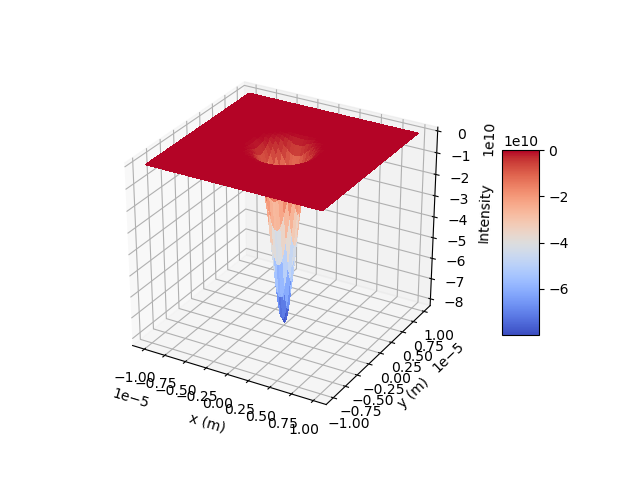

In [72]:
landscape_3d_xy(f)

<IPython.core.display.Javascript object>


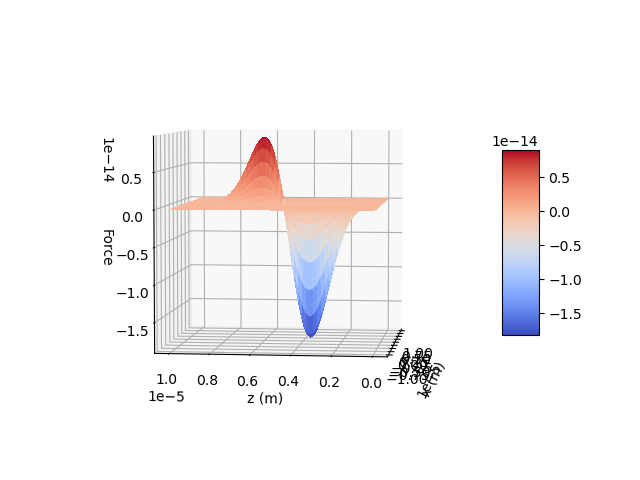

In [89]:
landscape_3d_xz(0)

### The general form of propagation (H$\rightarrow$I) and backpropagation (I$\rightarrow$H) are:
### $U(x,y) = \frac{e^{ikz}}{i\lambda z}e^{\frac{i\pi}{\lambda z}(x^2+y^2)} F\{U(\xi,\eta) e^{\frac{i\pi}{\lambda z}(\xi^2+\eta^2)} \}$
### $U(\xi,\eta) = -i\lambda z e^{ikz} \,e^{\frac{i\pi}{\lambda z}(\xi^2+\eta^2)} F^{-1}\{U(x,y) e^{\frac{i\pi}{\lambda z}(x^2+y^2)} \}$,  $z<0$
### The usual Fourier transform: $\int^{\infty}_{-\infty}\int^{\infty}_{-\infty} U(\xi,\eta) \times e^{-\frac{ik(x\xi + y\eta)}{z}} d\xi d\eta$

### If we choose field to be a gaussian, hologram is $A e^{-B(\xi^2+\eta^2)}$, where:
#### $A = -(iu_{0}\lambda z)e^{ikz} e^{\frac{-(z-f)^2}{\lambda f}}, B =  \pi^2[\frac{\lambda z^2}{f}-i\pi\lambda z]^{-1} - \frac{i\pi}{\lambda z}$

In [46]:
def holo_gaussian(z):
    #Plot hologram for Gaussian function -> z=-f should be hologram plane?
    xmax, dx = 1*10**-5, 1*10**-7
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    u_0 = np.sqrt(P/(pi*(w_0**2*(1+(z/z_R)**2))))
    k = 2*pi/wavelength
    A = -(1j*u_0*wavelength*z) * np.exp(1j*k*z) * np.exp(-(z-f)**2/(wavelength*f))
    B = pi**2 * (wavelength*z**2/f - 1j*pi*wavelength*z)**(-1) - (1j*pi/(wavelength*z))
    intensity = np.zeros([len(range(int(2*xmax/dx))),len(range(int(2*xmax/dx)))])
    for xi in range(int(2*xmax/dx)):
        for yi in range(int(2*xmax/dx)):
            x, y = xlist[xi], ylist[yi]
            u = A*np.exp(-B*(x**2 + y**2))
            intensity[xi][yi] = np.imag(u)**2 + np.real(u)**2
    plt.imshow(intensity, cmap = 'gray', interpolation = 'nearest')
    title = 'Holo @ z = ' + str(z)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    return

<IPython.core.display.Javascript object>


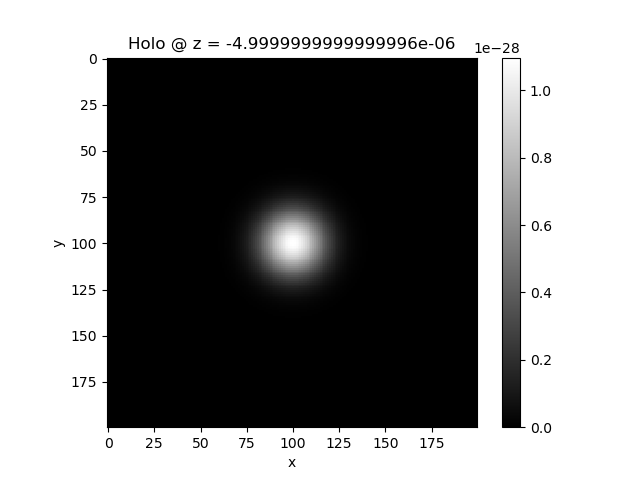

In [47]:
holo_gaussian(-f)

#### A Gaussian trap is a suitable trap for a light-seeking particle, while we are trying to trap a dark-seeking particle. For that purpose, a DOG trap (difference of Gaussians: fatter - narrower) can be implemented
#### $I(r) \propto e^{-\frac{r^2}{\Sigma^2}}-e^{-\frac{r^2}{\sigma^2}}$ at $z = f$, where $\Sigma > \sigma > 0$. 

In [182]:
%matplotlib notebook
def plot_intensity_DoG():
    #make a simple plot of intensity v. distance r at the focus
    f = 10e-5 #focal point
    u_0 = np.sqrt(P/(pi*(w_0**2*(1+(f/z_R)**2)))) #intensity is proportional to u_0^2. And u_0^2 is power/area
    Sigmasq, sigmasq = wavelength*2000*f, wavelength*1000*f#Sigma and sigma can be fixed to more suitable values. 
    rlist = np.arange(0,10e-4, 10e-6)
    intensity = [u_0**2 * (np.exp(-r**2/Sigmasq) - np.exp(-r**2/sigmasq)) for r in rlist]
    plt.plot(rlist, intensity, 'r-')
    plt.show()
    plt.xlabel('r')
    plt.ylabel('intensity')
    return

def landscape_3d_xy():
    #a 3D, rotatable plot of intensity at focus
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xmax = 1*10**-5
    X = np.linspace(-xmax, xmax, 100)
    Y = np.linspace(-xmax, xmax, 100)
    X,Y = np.meshgrid(X,Y)
    u_0 = np.sqrt(P/(pi*(w_0**2*(1+(f/z_R)**2)))) #intensity is proportional to u_0^2. And u_0^2 is power/area
    Sigmasq, sigmasq = wavelength*4*f, 2*wavelength*f #Sigma and sigma can be fixed to more suitable values
    R = np.sqrt(X**2 + Y**2)
    I = u_0**2 * (np.exp(-R**2/Sigmasq) - np.exp(-R**2/sigmasq))
    #F = proj_force(X,Y,z) #if we wish to plot force field instead
    surf = ax.plot_surface(X, Y, I, cmap = cm.coolwarm, linewidth=0, antialiased=False) #change I to F for force
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Intensity')
    #ax.set_zlabel('Force')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

<IPython.core.display.Javascript object>


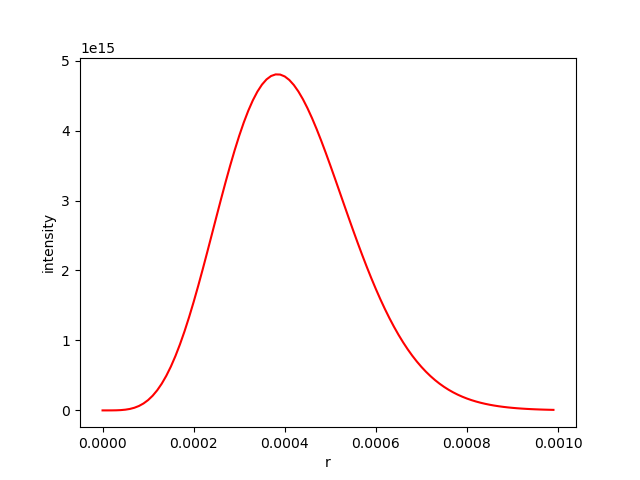

In [181]:
plot_intensity_DoG()

<IPython.core.display.Javascript object>


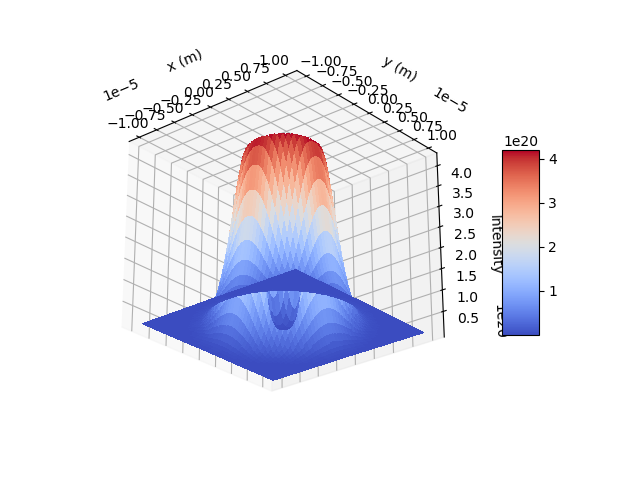

In [178]:
landscape_3d_xy()

#### The analytic computation of the hologram required to project a DoG is quite involved because the field goes as $\sqrt{I}$, and so we would be computing a Fourier Inverse transform of a term that goes like $(e^{-\frac{r^2}{\Sigma^2}}-e^{-\frac{r^2}{\sigma^2}})^{1/2}$. 
#### Instead, if one notes that the intensity of a DoG and the squared of a DoG have the same features (well at center, with bumps on either end), we can instead let the intensity be the square of a DoG, and then $u = e^{-\frac{r^2}{\Sigma^2}}-e^{-\frac{r^2}{\sigma^2}}$
#### If we proceed in this way, the computed hologram is
### $u(\xi,\eta,z) = \frac{-iu_{0}\pi}{\lambda z}e^{ikz + \frac{i\pi}{\lambda z}(\xi^2 + \eta^2)} \times [\frac{1}{a}e^{-\frac{\pi^2}{\lambda^2 z^2 a}(\xi^2+\eta^2)} - \frac{1}{b}e^{-\frac{\pi^2}{\lambda^2 z^2 b}(\xi^2+\eta^2)}]$, where $a = (\frac{1}{\Sigma^2}-\frac{i\pi}{\lambda z})$ and $b = (\frac{1}{\sigma^2}-\frac{i\pi}{\lambda z})$